In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -o -qq 'tiny-imagenet-200.zip'


--2020-08-24 08:35:30--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  31.9MB/s    in 12s     

2020-08-24 08:35:47 (19.3 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]



In [1]:
from tensorflow import keras
import os,sys
from matplotlib import pyplot
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np

In [2]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)


,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [7]:
# define a cnn model with four VGG blocks
def define_four_blocks_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(200, activation='softmax'))
    model.summary()
    return model

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()


In [9]:
# run the test harness for evaluating a model
def run_test_harness(model):
    # compile model
    model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])
    # create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
        width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                 batch_size=256, class_mode='categorical', shuffle=True, seed=42)

    test_it = test_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=256, shuffle=True, seed=42)

    # Create EarlyStopping callback which stopps after 5 epochs of non-increasing accuracy
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
    # fit model
    history = model.fit(train_it, steps_per_epoch=390,
        validation_data=test_it, validation_steps=20, epochs=25, callbacks=[early])
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it))
    print('Test Accuracy > %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)      

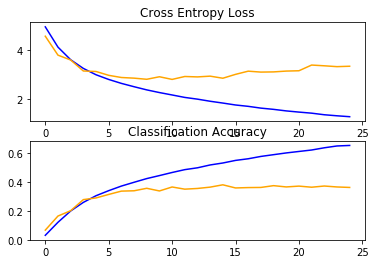

In [10]:
model4 = define_four_blocks_model()
run_test_harness(model4)

In [11]:
model4.save('4blocks-cnn-double-convnet.h5')